<a href="https://colab.research.google.com/github/saranshikens/Epoch-Tasks/blob/main/Task_Session_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**$\Huge \text{TASK SESSION-1}$**  
<br>
●	Support Vector Machines (SVMs)  
●	Singular Value Decomposition (SVD)  
●	Dimensionality reduction techniques (PCA, TSNE and more)  
●	Random Forests (including bagging and boosting)
<br>  
$\large \text{By - Saransh}$  


---



**$\huge \text{STEP-1: DATA PROCESSING AND INITIAL INSIGHTS}$**

**$\LARGE \text{Loading the Datasets}$**  
I will be using Kaggle's API machinery to load the datasets.

In [1]:
# Setting up Kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!bash -c "kaggle datasets download -d jessicali9530/lfw-dataset > /dev/null 2>&1"
!bash -c "kaggle datasets download -d davilsena/ckdataset > /dev/null 2>&1"

In [4]:
!unzip -q lfw-dataset.zip
!unzip -q ckdataset.zip

In [5]:
import numpy as np
import pandas as pd
import os
from PIL import Image



---



**$\LARGE \text{Reading the labelled data}$**

In [6]:
small_data = pd.read_csv("/content/ckextended.csv")
small_data.head()

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


The way the pixels have been stored is problematic.  
Each image has been reshaped to a vector, with all pixels stored in a single string.  
For our purpose, each pixel has to be a separate feature, i.e. we need to store  
each pixel as an individual feature and as an integer, not a string.

**$\LARGE \text{Processing the Labelled Data}$**

In [7]:
# 'Usage' serves no "use" for the task at hand
small_data = small_data.drop(columns=['Usage'])

# splits each string entry in small_data['pixels'], and returns a list of individual pixel values for each entry
small_data['pixels'] = small_data['pixels'].apply(lambda x: list(map(int, x.split())))

# each "pixel" in small_data['pixels'] needs to be stored as a separate feature, since we want to describe an image as a vector
pixels_df = pd.DataFrame(small_data['pixels'].tolist())

# the original string of pixels is no longer needed
small_data = small_data.drop(columns=['pixels'])
small_data = pd.concat([small_data, pixels_df], axis=1)
small_data.head()

,emotion,0,1,2,3,4,5,6,7,8,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,6,36,39,35,25,19,11,8,7,3,...,109,107,95,95,72,15,139,193,251,253
1,6,88,74,19,4,5,5,3,12,8,...,18,112,116,80,110,124,49,50,27,33
2,6,9,2,4,7,1,1,1,0,7,...,158,154,144,5,1,1,0,0,0,0
3,6,104,106,108,104,95,50,60,61,58,...,11,17,15,28,32,37,66,76,85,86
4,6,68,72,67,67,6,2,1,1,1,...,176,182,73,74,73,68,62,52,58,66




---



To gain more insights about the distribution of the emotions, we count the frequency of each emotion.

In [8]:
emotion_counts = small_data['emotion'].value_counts()
emotion_counts

,count
emotion,
6,593
5,83
3,69
1,59
0,45
4,28
2,25
7,18


Above table reveals a problem with the dataset.  
It is very imbalanced, with emotion '6' having more than 60% of the entries.  
This will give an unfair weightage to emotion '6' when we try to fit a model to  
this data, and try to access its accuracy and other metrics.  
Basically, if our model works only for emotion '6', even then its accuracy will be higher than it realistically should be.

We can take care of this using two approaches:

**$\Large \text{Approach-1: Dropping Emotion'6'}$**  
We can ignore the entries that are causing trouble.  

**$\Large \text{Approach-2: Randomly selecting entries for emotion '6'}$**  
Ignoring emotion '6', each emotion has on an average 47 entries.  
We may randomly select 47 entries for emotion '6', fit our model, repeat the process a certain number of times, and average out the results.  





---



**$\LARGE \text{Reading and Processing the Unlabelled data}$**

   
Images have been stored in the "lfw-deepfunneled" folder as follows:  
"**lfw-deepfunneled**" -> "**lfw-deepfunneled**" -> **Person's Name (Format: {FirstName}_{Surname} )** -> **image.jpg**  
We loop through the folders/directories, searching for .jpg images.  
When we encounter an image, we apply the these transformations:  


1.   Convert the image to grayscale.
2.   We want all our images (labelled and unlabelled both) to have the same size.  
 Since images in labelled data are 48 $\times$ 48, we resize these encountered images to the same.
3.   Currently, the image is a 48 $\times$ 48 matrix. To store the images in a single 2-D dataframe, we reshape the 48 $\times$ 48 matrix into a 1 $\times$ 2304 vector.




In [9]:
lfw_dir = "/content/lfw-deepfunneled/lfw-deepfunneled"

image_vectors = [] # we will store each image here, and later use it to make a pandas dataframe for the unlabelled data

for person_name in os.listdir(lfw_dir): # os.listdir(lfw_dir) returns a list of all files and folders in lfw_dir
    person_dir = os.path.join(lfw_dir, person_name) # we obtain the path of each folder by joining its name with lfw_dir
    if os.path.isdir(person_dir):
        for image_filename in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_filename)

            # Open the image
            img = Image.open(image_path)

            # Convert to grayscale
            img_gray = img.convert('L')

            # Resize to 48x48
            img_resized = img_gray.resize((48, 48))

            # Convert to numpy array and flatten into a 1x2304 vector
            img_array = np.array(img_resized)
            img_vector = img_array.flatten().tolist()

            image_vectors.append(img_vector)


large_data = pd.DataFrame(image_vectors)
large_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,8,8,8,8,8,8,8,8,8,8,...,57,131,191,167,139,121,120,125,126,126
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0




---



**$\LARGE \text{Singular Value Decomposition on Large Data}$**


Both of our data has 2304 features. Using all of them will be computationally  
expensive. Instead we can try to use the most significant features only.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

X = large_data - large_data.mean()
U, S, VT = np.linalg.svd(X, full_matrices=False)

# S is a diagonal matrix. The diagonal elements in S give us the proportion in
# which each component explains the variance of the original data. For convenience
# and interpretability we transform the proportions into ratios.
S = (S/np.sum(S))*100

S_df = pd.DataFrame({
    'Component': [f'S{i+1}' for i in range(len(S))],
    'Percent Explained Variance': np.round(S, 2)
})

**$\LARGE \text{Plotting } S_{df}$**

We will find out the distribution of the variance explained by each component in S_df.  
This will help us in deducing which "features" are the most important in describing the images in large_data.  
From here, we can reduce the dimensionality from 2304 to a significantly smaller number.

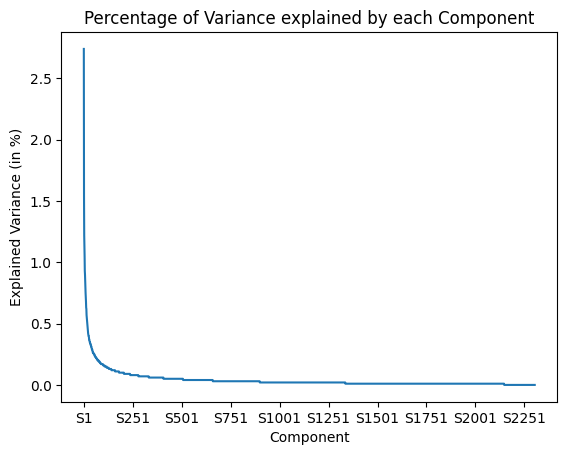

In [11]:
sns.lineplot(data=S_df, x='Component', y='Percent Explained Variance')
plt.title("Percentage of Variance explained by each Component")
plt.xticks(ticks=range(0, 2304, 250))
plt.ylabel("Explained Variance (in %)")
plt.show()

The elbow point of the distribution lies somewhere between 80 and 100.  
Instead of using all of the 2304 features, we will use only 100, reducing our  
load by more than 95%.



---



**$\huge \text{STEP-2: FEARURE ENGINEERING WITH PCA}$**

With Principal Component Analysis on the Unlabelled Data, we will extract the  
before mentioned 100 features.

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_large_data = scaler.fit_transform(large_data)

pca = PCA(n_components=100)
large_pca_data = pca.fit_transform(scaled_large_data)

large_pca_data_df = pd.DataFrame(large_pca_data, columns=[f'PC{i+1}' for i in range(large_pca_data.shape[1])])

# comparing the importance of the extracted features
explained_variance = pca.explained_variance_ratio_

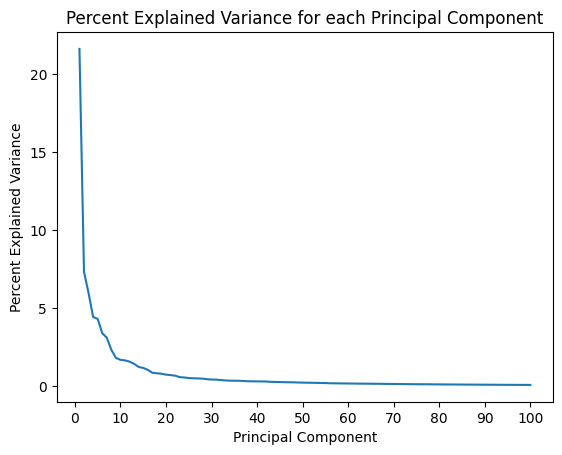

In [13]:
sns.lineplot(x=range(1, len(explained_variance)+1), y=explained_variance*100)
plt.xlabel('Principal Component')
plt.ylabel('Percent Explained Variance')
plt.title('Percent Explained Variance for each Principal Component')
plt.xticks(range(0, len(explained_variance)+1, 10))
plt.show()



---



**$\huge \text{STEP-3: SVM CLASSIFICATION AND EVALUATION}$**

**$\LARGE \text{Accounting for the Disbalance}$**

**$\large \text{APPROACH-1}$**

In [14]:
# remove the entries for which emotion=6
small_data_1 = small_data[small_data['emotion']!=6]

small_data_1 = small_data_1.drop(columns=['emotion'])

# we use our pre-trained pca model to transform small_data_1 into a low dimensionality space
small_data_1_pca = pca.transform(small_data_1)

# we name our features PC1, PC2, and so on...
small_data_1_pca_df = pd.DataFrame(small_data_1_pca, columns=[f'PC{i+1}' for i in range(small_data_1_pca.shape[1])])

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [16]:
X_pca_1 = small_data_1_pca_df

# in accordance with approach-1, we remove the entries where emotion=6
y_pca_1 = small_data.loc[small_data['emotion'] != 6, 'emotion']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_pca_1, y_pca_1, test_size=0.3, random_state=0, stratify=y_pca_1)

svm = SVC()

# we use different kernels for SVM, and use the best one out of them
hyper_param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.001, 0.1, 0.1],
    'gamma': ['scale', 0.01, 0.001]
}

# cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# search through the grid of hyper parameters, and use cross validation to return the best set out of them
grid_search = GridSearchCV(svm, hyper_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_1, y_train_1)

print("Best parameters:", grid_search.best_params_)


Best parameters: {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}


In [17]:
# we choose the best choices for the hyperparameters, and use them in our SVM model
best_svm = grid_search.best_estimator_

y_pred_1 = best_svm.predict(X_test_1)

print("Classification Report:")
print(classification_report(y_test_1, y_pred_1))

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57        14
           1       0.81      0.94      0.87        18
           2       0.57      0.50      0.53         8
           3       1.00      1.00      1.00        21
           4       0.22      0.25      0.24         8
           5       0.95      0.84      0.89        25
           7       0.40      0.40      0.40         5

    accuracy                           0.76        99
   macro avg       0.65      0.64      0.64        99
weighted avg       0.77      0.76      0.76        99



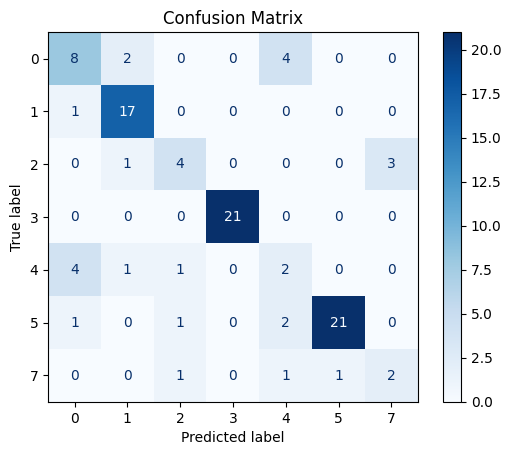

In [18]:
cm = confusion_matrix(y_test_1, y_pred_1)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_pred_1))
display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



---



**$\large \text{APPROACH-2}$**

First we will consider a single iteration and afterwards compare the result with  
the model using 100 iterations.

In [19]:
# we separate the entries with emotion 6
emotion_6_data = small_data[small_data['emotion'] == 6]

# selecting 47 random entries from emotion 6 data
random_emotion_6 = emotion_6_data.sample(n=47, random_state=0)

# getting the data where emotion is not 6
rest_of_data = small_data[small_data['emotion'] != 6]

# we combine the randomly selected emotion 6 data with the rest of the data
small_data_2 = pd.concat([random_emotion_6, rest_of_data])

In [20]:
small_data_2_dropped = small_data_2.drop(columns=['emotion'])

# we use our pre-trained pca model to transform small_data_2 into a low dimensionality space
small_data_2_pca = pca.transform(small_data_2_dropped)

# we name our features PC1, PC2, and so on...
small_data_2_pca_df = pd.DataFrame(small_data_2_pca, columns=[f'PC{i+1}' for i in range(small_data_2_pca.shape[1])])

In [21]:
X_pca_2 = small_data_2_pca_df
y_pca_2 = small_data_2['emotion']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_pca_2, y_pca_2, test_size=0.3, random_state=0, stratify=y_pca_2)

svm = SVC()

# we use different kernels for SVM, and use the best one out of them
hyper_param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.001, 0.1, 0.1],
    'gamma': ['scale', 0.01, 0.001]
}

# cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# search through the grid of hyper parameters, and use cross validation to return the best set out of them
grid_search = GridSearchCV(svm, hyper_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_2, y_train_2)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}


In [22]:
# we choose the best choices for the hyperparameters, and use them in our SVM model
best_svm = grid_search.best_estimator_

y_pred_2 = best_svm.predict(X_test_2)

print("Classification Report:")
print(classification_report(y_test_2, y_pred_2))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.57      0.53        14
           1       0.77      0.94      0.85        18
           2       0.57      0.50      0.53         8
           3       0.95      1.00      0.98        21
           4       0.14      0.12      0.13         8
           5       0.95      0.80      0.87        25
           6       0.62      0.57      0.59        14
           7       0.60      0.60      0.60         5

    accuracy                           0.73       113
   macro avg       0.64      0.64      0.64       113
weighted avg       0.73      0.73      0.72       113



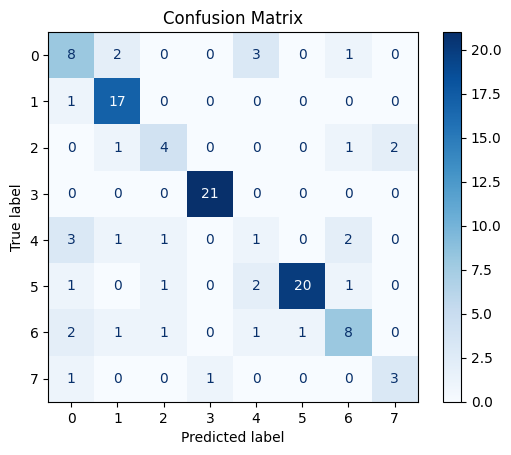

In [23]:
cm = confusion_matrix(y_test_2, y_pred_2)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_pred_2))
display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



---



**$\large \text{INITIALIZING THE EVALUATION METRICS}$**

In [25]:
# we will store results from each iteration in these lists and dictionaries
accuracy_scores = []
confusion_matrices = []

# since we have to output the metrics for each emotion class, we initialize the keys
# as the emotions themselves
precision_scores = {str(i): [] for i in range(8)}
recall_scores = {str(i): [] for i in range(8)}
f1_scores = {str(i): [] for i in range(8)}

n_iterations = 100



---



**$ \large \text{RUNNING THE ITERATIONS}$**

In [26]:
for i in range(n_iterations):
    if (i+1)%10==0:
        print(f"Iteration {i+1}/{n_iterations}")

    # we separate the entries with emotion 6
    emotion_6_data = small_data[small_data['emotion'] == 6]

    # selecting 47 random entries from emotion 6 data
    # we will use a different random state for each iteration
    random_emotion_6 = emotion_6_data.sample(n=47, random_state=i)

    # geting the data where emotion is not 6
    rest_of_data = small_data[small_data['emotion'] != 6]

    # we combine the randomly selected emotion 6 data with the rest of the data
    small_data_2 = pd.concat([random_emotion_6, rest_of_data])

    # Apply PCA transformation
    small_data_2_dropped = small_data_2.drop(columns=['emotion'])

    # we use our pre-trained pca model to transform small_data_2 into a low dimensionality space
    small_data_2_pca = pca.transform(scaler.transform(small_data_2_dropped))

    # we name our features PC1, PC2, and so on...
    small_data_2_pca_df = pd.DataFrame(small_data_2_pca, columns=[f'PC{j+1}' for j in range(small_data_2_pca.shape[1])])

    X_pca_2 = small_data_2_pca_df
    y_pca_2 = small_data_2['emotion']

    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_pca_2, y_pca_2, test_size=0.3, random_state=0, stratify=y_pca_2)

    svm = SVC()

    # we use different kernels for SVM, and use the best one out of them
    hyper_param_grid = {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.001, 0.1, 0.1],
        'gamma': ['scale', 0.01, 0.001]
    }

    # cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    # search through the grid of hyper parameters, and use cross validation to return the best set out of them
    grid_search = GridSearchCV(svm, hyper_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X_train_2, y_train_2)

    best_svm = grid_search.best_estimator_

    y_pred_2 = best_svm.predict(X_test_2)

    # we will calculate all the evaluation metrics and store them in the lists
    report = classification_report(y_test_2, y_pred_2, output_dict=True)
    accuracy_scores.append(report['accuracy'])
    for label in precision_scores.keys():
        precision_scores[label].append(report[label]['precision'])


    for label in recall_scores.keys():
         recall_scores[label].append(report[label]['recall'])


    for label in f1_scores.keys():
        f1_scores[label].append(report[label]['f1-score'])

    # to determining the overall confusion matrix, we sum up all the confusion matrices
    if i == 0:
        overall_confusion_matrix = confusion_matrix(y_test_2, y_pred_2, labels=np.unique(y_pca_2))
    else:
        overall_confusion_matrix += confusion_matrix(y_test_2, y_pred_2, labels=np.unique(y_pca_2))

Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
Iteration 100/100


**$\large \text{AVERAGING OUT THE METRICS}$**

In [27]:
average_confusion_matrix = overall_confusion_matrix / n_iterations
average_accuracy = np.mean(accuracy_scores)
average_precision = {label: np.mean(precision_scores[label]) for label in precision_scores.keys()}
average_recall = {label: np.mean(recall_scores[label]) for label in recall_scores.keys()}
average_f1 = {label: np.mean(f1_scores[label]) for label in f1_scores.keys()}



---



**$ \large \text{THE AVERAGE CLASSIFICATION REPORT}$**

In [28]:
print(f"\nAverage Classification Report over {n_iterations} iterations:")
print(f"Average Accuracy: {average_accuracy:.4f}")
print("Average Precision:")
for label, avg_prec in average_precision.items():
    print(f"  {label}: {avg_prec:.4f}")
print("Average Recall:")
for label, avg_rec in average_recall.items():
    print(f"  {label}: {avg_rec:.4f}")
print("Average F1-score:")
for label, avg_f1_score in average_f1.items():
    print(f"  {label}: {avg_f1_score:.4f}")


Average Classification Report over 100 iterations:
Average Accuracy: 0.7466
Average Precision:
  0: 0.5365
  1: 0.8615
  2: 0.6616
  3: 0.9543
  4: 0.2514
  5: 0.9615
  6: 0.5886
  7: 0.4131
Average Recall:
  0: 0.5479
  1: 0.9928
  2: 0.5312
  3: 0.9990
  4: 0.2162
  5: 0.8668
  6: 0.5314
  7: 0.5520
Average F1-score:
  0: 0.5394
  1: 0.9213
  2: 0.5872
  3: 0.9761
  4: 0.2296
  5: 0.9111
  6: 0.5505
  7: 0.4662




---



**$ \large \text{THE AVERAGE CONFUSION MATRIX}$**

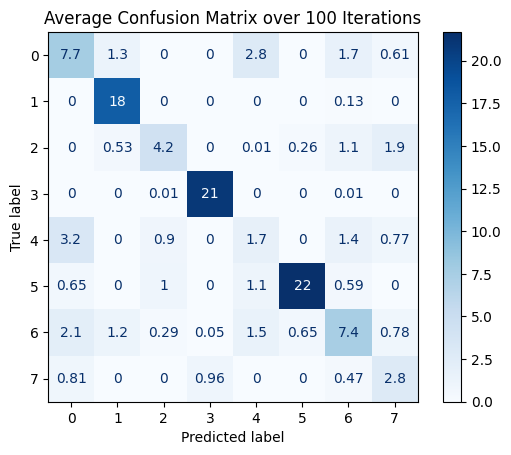

In [29]:
display = ConfusionMatrixDisplay(confusion_matrix=average_confusion_matrix, display_labels=np.unique(y_pca_2))
display.plot(cmap='Blues')
plt.title(f"Average Confusion Matrix over {n_iterations} Iterations")
plt.show()



---

